In [62]:
import pandas as pd

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error

In [140]:
import pickle

In [112]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

    df = df[((df.duration >= 1) & (df.duration <= 60))]

    categorical = ['PULocationID','DOLocationID']

    df[categorical] = df[categorical].astype(str)
    
    return df

In [113]:
df_train = read_dataframe('data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('data/green_tripdata_2024-02.parquet')

In [114]:
len(df_train), len(df_val)

(54373, 51497)

In [128]:
df_train['pu_do'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['pu_do'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [130]:
categorical = ['pu_do']#['PULocationID','DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean Sq. error is: 5.982617137342204 minutes


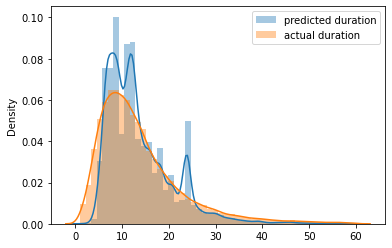

In [139]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

sns.distplot(y_pred,label='predicted duration')
sns.distplot(y_train,label='actual duration')

plt.legend()

Mean_sqError = mean_squared_error(y_val, y_pred, squared=False)
print(f"Mean Sq. error is: {Mean_sqError} minutes")

In [141]:
with open('model/model_linreg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [132]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.583747374286971